# Plots of Single TimePoint for a specific Region on Injection

This scripts creates the followinf images:
- barplot with the most mean dense region of all mice of a specific timepoint and region injection
- 2D HeatMaps of mean density ROI of all mice of a specific timepoint and region injection

**ATTENTION**: 
- as the script uses code taken from `4_2D_heatmpas_single_brain.ipynb`, check it to see the dependencies to install and the differenrt parameters to choose from.
- it is decided to plot and analyze all the ROIs, not just the leaves

## Packages

In [3]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import brainglobe_heatmap as bgh #Please use a VE where brainrender is installed
from brainglobe_atlasapi import BrainGlobeAtlas
from PIL import Image
import cv2
import re
import matplotlib.colors as mcolors

## Mandatory Inputs

In [4]:
## General Inputs

# Dir of the project (if script is run on batch mode, i.e. for all brains of the project)
dir_project = "/run/user/1000/gvfs/smb-share:server=upcourtinenas,share=cervical/CERVICAL_ID/connectome_analysis/final_dataset"

# Csv file with all the brains data
csv_file = "/run/user/1000/gvfs/smb-share:server=upcourtinenas,share=cervical/CERVICAL_ID/Connectome_analysis/Final_dataset/Results/all_brains.csv"

# number of the ROI to display in a plot
n_roi_displayed = 10 

## Imputs for Barplots

# List of region to injection to invesigate (one for each folder in the porject)
region_injections = ["DR", "STN", "PARN", "IF", "GPi", "GPe", "CU", "BST"]
# List of Timepoints to investigate
timepoints = ["Uninjured", "1 weeks", "8 weeks"]

## Imputs for HeatMaps

# Choose how many slices show, initial and final cuts
start_cut = 0 #from olfacotry bulb
end_cut = 13000 #to myelenchephalon
step = 5000

# Select an atlas
atlas_name = "allen_mouse_50um"
bg_atlas = BrainGlobeAtlas(atlas_name, check_latest=False)

# Show only leaves nodes
only_leaves = False
    #ATTENTION: if you show all the ROIs it is importnat the irder that they have in the df
        # Indeed if the "root" is at the end, i will see only it because it is put on top of everything

# fps of the video
fps = 5

# Choose the fraction of the colormap to start from (0.0 = start, 1.0 = end)
start_fraction = 0.1  # Adjust this value as needed

# Show or not colorbar in final images
show_colorbar = False
            #ATTENTION: ratios
                # if colormap is there: left_ratio=0.493,right_ratio=0.507
                # if colormap is NOT there: left_ratio=0.511,right_ratio=0.489
            #ATTENTION: if the ratios are not correct, use the box "To see where to cut" to find the best ratios
if show_colorbar == True:
    left_ratio=0.493
    right_ratio=0.507
else:
    left_ratio=0.511
    right_ratio=0.489

## Usefull Functions

In [5]:
def split_and_merge_png_images(image_path_left, image_path_right, output_path, left_ratio=0.493, right_ratio=0.507):
    """
    Splits and merges two PNG images with the specified ratio for each side.

    :param image_path1: Path to the left image.
    :param image_path2: Path to the right image.
    :param output_path: Path to save the combined image.
    :param left_ratio: Ratio of the width to take from the left image.
    :param right_ratio: Ratio of the width to take from the right image.
    """
    # Load PNG images
    img1 = Image.open(image_path_left)
    img2 = Image.open(image_path_right)

    # Ensure images have the same height
    if img1.size[1] != img2.size[1]:
        raise ValueError("Images must have the same height.")

    # Get image dimensions
    width1, height1 = img1.size
    width2, height2 = img2.size

    # Calculate cropping dimensions based on the provided ratios
    left_crop_width = int(width1 * left_ratio)
    right_crop_width = int(width2 * right_ratio)

    # Crop each image according to the calculated dimensions
    left_half_img1 = img1.crop((0, 0, left_crop_width, height1))
    right_half_img2 = img2.crop((width2 - right_crop_width, 0, width2, height2))

    # Save the intermediate halves --> TEST WHERE TO CUT!!!
    #left_half_img1.save('left_half.png')
    #right_half_img2.save('right_half.png')

    # Create a new image with combined width
    new_width = left_half_img1.width + right_half_img2.width
    new_image = Image.new('RGB', (new_width, height1))

    # Paste halves into the new image
    new_image.paste(left_half_img1, (0, 0))
    new_image.paste(right_half_img2, (left_half_img1.width, 0))

    # Save the combined image
    print(f"Saving merged heatmap {output_path}")
    new_image.save(output_path)

def extract_number(filename):
    """
    Extract the number from the filename.
    Assumes filename is in the format 'number.png'.
    """
    match = re.search(r'(\d+)', filename)
    return int(match.group(1)) if match else 0

def create_custom_cmap(start_fraction=0.1):
    """
    Create a custom colormap starting from a specific fraction of the Reds colormap.
    
    Parameters:
    start_fraction (float): Fraction of the Reds colormap to start from (0.0 to 1.0).
    
    Returns:
    LinearSegmentedColormap: A custom colormap starting from the specified fraction.
    """
    # Ensure the starting fraction is within the range [0, 1]
    start_fraction = np.clip(start_fraction, 0, 1)
    
    # Get the 'Reds' colormap
    reds = plt.get_cmap('Reds')

    # Extract the colormap data
    n_colors = reds.N
    colors = reds(np.linspace(0, 1, n_colors))

    # Calculate the index to start from
    start_index = int(start_fraction * (n_colors - 1))
    
    # Create the custom colormap starting from the chosen fraction
    custom_colors = colors[start_index:]
    custom_cmap = mcolors.LinearSegmentedColormap.from_list('custom_reds', custom_colors)
    
    return custom_cmap

def data_summary(data, varname, groupnames):
    """
    Function to calculate the mean and standard error for each group, preserving the original order.

    Parameters:
    - data: A pandas DataFrame containing the data.
    - varname: The name of the column containing the variable to be summarized (string).
    - groupnames: A list of column names to be used as grouping variables (list of strings).

    Returns:
    - data_sum: A pandas DataFrame with mean and standard error for each group, preserving the original order.
    """
    
    # Add an index column to preserve the original order
    data['_order'] = range(len(data))
    
    # Group the data by the specified group names
    grouped = data.groupby(groupnames)
    
    # Calculate the mean and standard error for the specified variable
    data_sum = grouped[varname].agg(
        mean='mean', 
        std='std', 
        count='count'
    ).reset_index()
    
    # Calculate standard error
    data_sum['sem'] = data_sum['std'] / np.sqrt(data_sum['count'])
    
    # Merge the summary with the original data to preserve the order
    data_sum = pd.merge(data[groupnames + ['_order']], data_sum, on=groupnames).sort_values('_order')

    # Check for duplicates in the summary DataFrame
    if data_sum.duplicated(subset=groupnames).any():
        #print("Warning: Duplicates found in the summarized data!")
        # Drop duplicates, keeping the first occurrence
        data_sum = data_sum.drop_duplicates(subset=groupnames)
    
    # Sort the summary DataFrame based on the preserved order from the original data
    data_sum['_order'] = data.groupby(groupnames)['_order'].first().values
    data_sum = data_sum.sort_values('_order')
    
    # Drop the temporary _order column
    data_sum = data_sum.drop(columns=['_order'])
    
    # Rename the mean and sem columns
    data_sum = data_sum.rename(columns={'mean': varname + '_mean', 'sem': varname + '_sem', 'std': varname + '_std'})
    
    # Drop the 'std' and 'count' columns, as they are not needed
    #data_sum = data_sum.drop(columns=['std', 'count'])
    
    return data_sum

## Read csv with all brains

In [6]:
df_all = pd.read_csv(csv_file)

## Barplots Most Dense ROI of a TimePoint

In [13]:
# Loop through the folder contents
for dir_inj in os.scandir(dir_project):

    # If the file is not a folder, exit
    if not dir_inj.is_dir():
        continue
    # If the folder is not an injetion folder, exit
    if not os.path.basename(dir_inj.path) in region_injections:
        continue

    # Save injection_side name
    injection_region = os.path.basename(dir_inj.path)

    for dir_timepoint in os.scandir(dir_inj):

        # If the file is not a folder, exit
        if not dir_timepoint.is_dir():
            continue
        # If the folder is not an injetion folder, exit
        if not os.path.basename(dir_timepoint.path) in timepoints:
            continue

        # Create Results folder if not yet present
        dir_results = dir_timepoint.path + "/Results"
        os.makedirs(dir_results, exist_ok=True)

        # Save timepoint
        timepoint = os.path.basename(dir_timepoint.path)

        print(f"Processing {injection_region} {timepoint}")

        # Select only mice with specifi injection region
        df_temp = df_all[df_all["Region Injection"] == injection_region]
        # Select only mice with speicific timepoint
        df_temp = df_temp[df_temp["TimePoint"] == timepoint]

        # In case the df is empty
        if df_temp.shape[0] == 0:
            print(f"\tATTENTION: No data for {injection_region} {timepoint}")
            continue

        # Step 1: Calculate the mean cell density for each ROI
        mean_cell_density = df_temp.groupby('ROI')['Cell Density'].mean().reset_index()
        mean_cell_density.columns = ['ROI', 'Mean Cell Density']

        # Step 2: Sort ROIs by mean cell density and select the top N ROIs
        top_roi = mean_cell_density.sort_values(by='Mean Cell Density', ascending=False)
        top_roi = top_roi.head(n_roi_displayed)
        top_rois = top_roi['ROI'].tolist()

        # Step 3: Filter the data for the top N ROIs
        df_top_rois = df_temp[df_temp['ROI'].isin(top_rois)]

        # Step 4: Create the plot for the top N ROIs
        fig, ax = plt.subplots(figsize=(20,10))

        # Plot mean and standard deviation for each top ROI
        for roi in top_rois:

            # Filter data for the current ROI
            df_roi = df_top_rois[df_top_rois['ROI'] == roi]

            #NB EACH ROW IS A SAMPLE --> useful for calculating the sme

            # Calculate mean and standard error
            mean_value = df_roi['Cell Density'].mean()
            std_error = df_roi['Cell Density'].std() / np.sqrt(len(df_roi))
            std_value = df_roi['Cell Density'].std()
            
            # Plot the bar for the mean with error bar for std
            ax.bar(roi, mean_value, yerr=std_error, capsize=5, label=f'{roi} (mean ± sme)', color = 'lightblue', alpha=0.7)

            # Add the jittered swarm plot
            sns.swarmplot(data=df_roi, x='ROI', y='Cell Density', color='black', alpha=0.6)

        # Add Full name of ROIs
        textstr = df_top_rois[["Region", "Name"]].drop_duplicates(subset="Region").to_string(index=False) # Creates text to put inside, i.e. the 2 cols of the df
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.5) # Properties text
        ax.text(0.7, 1, textstr, transform=ax.transAxes, fontsize=8, verticalalignment='top', multialignment="left", bbox=props)

        # Add labels and title
        ax.set_xlabel('ROI')
        ax.set_ylabel('Value')
        ax.set_title(f'Mean and SME for the Top {n_roi_displayed} ROIs with Highest Mean Cell Density')
        #ax.legend(title='ROIs')
        ax.legend().set_visible(False)
        plt.xticks(rotation=45)
        #ax.tight_layout()

        ####
        #plt.show()
        #raise StopExecution
        ####

        fig.savefig(dir_results + "/barplots_most_dense_ROI.pdf")

        print(f"\tSuccess in saving plot.")

        #######

        # Save memory
        plt.close('all')

Processing BST Uninjured
	ATTENTION: No data for BST Uninjured
Processing CU Uninjured
	ATTENTION: No data for CU Uninjured
Processing DR 8 weeks
	Success in saving plot.
Processing DR Uninjured
	Success in saving plot.
Processing DR 1 weeks
	Success in saving plot.
Processing GPe 8 weeks
	Success in saving plot.
Processing GPe Uninjured
	Success in saving plot.
Processing GPe 1 weeks
	Success in saving plot.
Processing GPi Uninjured
	Success in saving plot.
Processing IF Uninjured
	Success in saving plot.
Processing PARN Uninjured
	Success in saving plot.
Processing STN Uninjured
	Success in saving plot.


## Barplots Most Dense ROI of a TimePoint with Contralateral

In [14]:
# Loop through the folder contents
for dir_inj in os.scandir(dir_project):

    # If the file is not a folder, exit
    if not dir_inj.is_dir():
        continue
    # If the folder is not an injetion folder, exit
    if not os.path.basename(dir_inj.path) in region_injections:
        continue

    # Save injection_side name
    injection_region = os.path.basename(dir_inj.path)

    for dir_timepoint in os.scandir(dir_inj):

        # If the file is not a folder, exit
        if not dir_timepoint.is_dir():
            continue
        # If the folder is not a timepoint folder, exit
        if not os.path.basename(dir_timepoint.path) in timepoints:
            continue

        # Create Results folder if not yet present
        dir_results = dir_timepoint.path + "/Results"
        os.makedirs(dir_results, exist_ok=True)

        # Save timepoint
        timepoint = os.path.basename(dir_timepoint.path)

        print(f"Processing {injection_region} {timepoint}")

        # Select only mice with specifi injection region
        df_temp = df_all[df_all["Region Injection"] == injection_region]
        # Select only mice with speicific timepoint
        df_temp = df_temp[df_temp["TimePoint"] == timepoint]

        # In case the df is empty
        if df_temp.shape[0] == 0:
            print(f"\tATTENTION: No data for {injection_region} {timepoint}")
            continue

        # Step 1: Calculate the mean cell density for each ROI
        mean_cell_density = data_summary(df_temp, varname="Cell Density", groupnames=["TimePoint", "Region Injection", "ROI", "Region", "Side", "Name"])
            #all reduntant to group by them, but in this way trhe coluns are mantaind

        #print(mean_cell_density)

        # Step 2: Sort ROIs by mean cell density and select the top N ROIs
        df_top_roi = mean_cell_density.sort_values(by='Cell Density_mean', ascending=False).head(n_roi_displayed)
        name_max_regions = df_top_roi['ROI'].tolist()
        values_max_regions = df_top_roi["Cell Density_mean"].to_list()

        name_contralateral_regions = []
        values_contralateral_regions = []

        for idx, row in df_top_roi.iterrows():

            #info relative to the max region
            region = row['Region']
            side = row['Side']
            contralateral_side = 'Right' if side == 'Left' else 'Left'
            
            # Retrieve contralateral density from the map
            name_contralateral_regions.append(mean_cell_density[(mean_cell_density["Region"] == region) & (mean_cell_density["Side"] == contralateral_side)]["ROI"].values[0])
            values_contralateral_regions.append(mean_cell_density[(mean_cell_density["Region"] == region) & (mean_cell_density["Side"] == contralateral_side)]["Cell Density_mean"].values[0])

        # Print the filtered DataFrame for debugging
        #print(df_top_rois)

        width = 0.9
        ind = np.arange(len(values_max_regions))
        fig, ax = plt.subplots(figsize=(20,10))
        ax.bar(x=ind, height=values_max_regions, width=width,align='center', label='Max Regions')
        ax.bar(x=ind, height=values_contralateral_regions, width=width/3,  align='center', label='Contralateral Regions')
        ax.legend()
        plt.xticks(ind, name_max_regions, rotation = 45)
        #plt.tight_layout()

        # Add Full name of ROIs
        textstr = df_top_roi[["Region", "Name"]].drop_duplicates(subset="Region").to_string(index=False)
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.5) # Properties text
        ax.text(0.8, 0.9, textstr, transform=ax.transAxes, fontsize=8, verticalalignment='top', multialignment="left", bbox=props)

        ####
        #plt.show()
        #raise StopExecution
        ####

        fig.savefig(dir_results + "/barplots_most_dense_ROI_with_contralateral.pdf")

        print(f"\tSuccess in saving plot.")


        #######

        # Save memory
        plt.close('all')


Processing BST Uninjured
	ATTENTION: No data for BST Uninjured
Processing CU Uninjured
	ATTENTION: No data for CU Uninjured
Processing DR 8 weeks
	Success in saving plot.
Processing DR Uninjured
	Success in saving plot.
Processing DR 1 weeks
	Success in saving plot.
Processing GPe 8 weeks
	Success in saving plot.
Processing GPe Uninjured
	Success in saving plot.
Processing GPe 1 weeks
	Success in saving plot.
Processing GPi Uninjured
	Success in saving plot.
Processing IF Uninjured
	Success in saving plot.
Processing PARN Uninjured
	Success in saving plot.
Processing STN Uninjured
	Success in saving plot.


## Mean HeatMaps

Please check the script `4_2D_heatmpas_single_brain.ipynb` for a detailed explanation of the following code (dependencies, parameters, ...).

#### Create Custum cmap

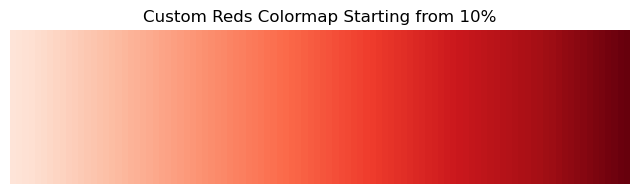

In [23]:
# Create the custom colormap
    #chnage "start_fraction" to start the colormap from a higher or lower color
custom_cmap = create_custom_cmap(start_fraction=start_fraction)

# Test the custom colormap
data = np.linspace(0, 1, 100).reshape(1, -1)
plt.figure(figsize=(8, 2))
plt.imshow(data, aspect='auto', cmap=custom_cmap)
plt.axis('off')
plt.title(f'Custom Reds Colormap Starting from {start_fraction * 100:.0f}%')
plt.show()

#### Create Heatmaps 

**Attention**: the following HeatMaps depict the mean density, not the density of a single brain.

In [24]:
# For Debugging: how many brains process
brains_to_process = 2
    # n --> if you want to proecces a subset
    # None --> if you want to process all

brain_processed = 0

# Loop through the folder contents
for dir_inj in os.scandir(dir_project):

    # If the file is not a folder, exit
    if not dir_inj.is_dir():
        continue
    # If the folder is not an injetion folder, exit
    if not os.path.basename(dir_inj.path) in region_injections:
        continue

    # Save injection_region name
    injection_region = os.path.basename(dir_inj.path)

    for dir_timepoint in os.scandir(dir_inj):

        # If the file is not a folder, exit
        if not dir_timepoint.is_dir():
            continue
        # If the folder is not an injetion folder, exit
        if not os.path.basename(dir_timepoint.path) in timepoints:
            continue

        # Save timepoint name
        timepoint = os.path.basename(dir_timepoint.path)

        ##############################################
        ### CREATE FOLDERS ###########################
        ##############################################

        # Create Results folder if not yet present
        dir_results = dir_timepoint.path + "/Results"
        os.makedirs(dir_results, exist_ok=True)

        # Make a dir for images (if doesn't yet exist)
        dir_images_name = os.path.join(dir_results, "2D_heatmaps")
        #print(dir_images_name)
        os.makedirs(dir_images_name, exist_ok=True)

        #Create a folder where to store them
        heatmaps_dir_left = os.path.join(dir_images_name, "Left")
        heatmaps_dir_right = os.path.join(dir_images_name, "Right")
        heatmaps_dir_merged = os.path.join(dir_images_name,"Merged") 
        os.makedirs(heatmaps_dir_left, exist_ok=True)
        os.makedirs(heatmaps_dir_right, exist_ok=True)
        os.makedirs(heatmaps_dir_merged, exist_ok=True)

        print(f"Processing {injection_region} {timepoint}")

        ##############################################
        ### CREATE DF WITH MEAN VALUES ###############
        ##############################################

        # Select only mice with specifi injection region
        df_temp = df_all[df_all["Region Injection"] == injection_region]
        # Select only mice with speicific timepoint
        df_temp = df_temp[df_temp["TimePoint"] == timepoint]

        # In case the df is empty
        if df_temp.shape[0] == 0:
            continue

        # Calculate the mean cell density for each ROI
        df = data_summary(df_temp, "Cell Density", ["ROI", "Region", "Side", "IsLeaf"]) 
            #ATTENTION:
                # no need no group with other varibales, df alredy filtered before
                # when we forup the importnat is to use "ROI", all the other varibales are coprrelated to ROI so it is like grouping in ther same way
        #df_temp.groupby('ROI')['Cell Density'].mean().reset_index()

        brain_processed +=1

        if brains_to_process != None: #Only if I want ot precess a speififc number of brains
            if brain_processed > brains_to_process:
                continue

        #print(df)

        ##############################################
        ### OBSERVATIONS #############################
        ##############################################

        # Attention: The heatmas will show all regions, not a subset of the most dense

        ##############################################
        ### CREATE HEATMAPS LEFT #####################
        ##############################################

        side = "Left"

        df_side = df[df["Side"] == side]  # Take the ROI only from one side

        if only_leaves: # To display only the leaves ROIs
            df_side = df[df["IsLeaf"] == True]

        # Use only the ROI that are present in the atlas
        df_side = df_side[df_side['Region'].isin(bg_atlas.lookup_df["acronym"].to_list())]

        # Create the dictionary --> NB take the name withounf left or right
        # ex: dict{"CA1": 10, "ENT": 40, ...}
        cell_density_data = dict(zip(df_side['Region'], df_side['Cell Density_mean']))

        #print(cell_density_data)

        # Iterate over cuts range
        for cut in range(start_cut, end_cut+1, step): # +1 so I can take alos the last slice

            print(f"Porcessing cut number {side}-{cut}")
            
            # Create Heatmap object
            f = bgh.Heatmap(
                cell_density_data,
                position=cut,
                orientation="frontal",  # Adjust orientation as needed
                title="", #f"Side: {side} - Slice position: {cut}",
                vmin=0,
                vmax=0.01,
                cmap=custom_cmap,
                atlas_name=atlas_name,
                format='2D', 
                hemisphere=side.lower(), #Attention lower case
                label_regions=False
            )
            
            # Save the figure
            fig = f.my_plot(show_colorbar=show_colorbar, show_legend=False, xlabel="", ylabel="", hide_axes=True) 
                # ATTENTION: MY PLOT IS A CUSTUM FUNCTION
                    #just go in the file brainrender-env/lib/python3.9/site-packages/brainglobe_heatmap/heatmaps.py
                    #create a new fucntion my_plot that copies the function plot()
                    #and comment out the plt.show() at the end
            fig_path = os.path.join(dir_images_name, side, f'{cut}.png')
            fig.savefig(fig_path, dpi=100)
            print(f"Saved figure: {cut}.png\n")
            plt.close(fig)  # Close the figure to free memory

        
        ##############################################
        ### CREATE HEATMAPS RIGHT #####################
        ##############################################

        # Attention: Show all regions, not a subset of the most dense

        side = "Right"

        df_side = df[df["Side"] == side]  # Take the ROI only from one side

        if only_leaves: # To display only the leaves ROIs
            df_side = df[df["IsLeaf"] == True]

        # Use only the ROI that are present in the atlas
        df_side = df_side[df_side['Region'].isin(bg_atlas.lookup_df["acronym"].to_list())]

        # Create the dictionary --> NB take the name withounf left or right
        # ex: dict{"CA1": 10, "ENT": 40, ...}
        cell_density_data = dict(zip(df_side['Region'], df_side['Cell Density_mean']))

        #print(cell_density_data)

        # Iterate over cuts range
        for cut in range(start_cut, end_cut+1, step): # +1 so I can take alos the last slice

            print(f"Porcessing cut number {side}-{cut}")
            
            # Create Heatmap object
            f = bgh.Heatmap(
                cell_density_data,
                position=cut,
                orientation="frontal",  # Adjust orientation as needed
                title="", #f"Side: {side} - Slice position: {cut}",
                vmin=0,
                vmax=0.01,
                cmap=custom_cmap,
                atlas_name=atlas_name,
                format='2D', 
                hemisphere=side.lower(), #Attention lower case
                label_regions=False
            )
            
            # Save the figure
            fig = f.my_plot(show_colorbar=show_colorbar, show_legend=False,xlabel="", ylabel="", hide_axes=True) 
                # ATTENTION: MY PLOT IS A CUSTUM FUNCTION
                    #just go in the file brainrender-env/lib/python3.9/site-packages/brainglobe_heatmap/heatmaps.py
                    #create a new fucntion my_plot that copies the function plot()
                    #and comment out the plt.show() at the end
            fig_path = os.path.join(dir_images_name, side, f'{cut}.png')
            fig.savefig(fig_path, dpi=100)
            print(f"Saved figure: {cut}.png\n")
            plt.close(fig)  # Close the figure to free memory


        ##############################################
        ### MERGE IMAGES #############################
        ##############################################
        
        for root, dirs, files in os.walk(heatmaps_dir_left):
            for file in files:
                file_path_left = os.path.join(heatmaps_dir_left, file) #path fo the file
                file_path_right = os.path.join(heatmaps_dir_right, file)
                file_path_merged = os.path.join(heatmaps_dir_merged, file)
                split_and_merge_png_images(image_path_left=file_path_right, #ATTENTION, are inverted
                                            image_path_right=file_path_left,  
                                            output_path=file_path_merged, 
                                            left_ratio=left_ratio,right_ratio=right_ratio)
                
                #ATTENTION: ratios
                    # if colormap is there: left_ratio=0.493,right_ratio=0.507
                    # if colormap is NOT there: left_ratio=0.511,right_ratio=0.489


        ##############################################
        ### VIDEO ####################################
        ##############################################

        # Path of the video to save
        video_path = heatmaps_dir_merged + '/video_merged_heatmaps.mp4'

        # Get the list of image files in the folder
        images = [img for img in os.listdir(heatmaps_dir_merged) if img.endswith(".png")]
        images.sort(key=extract_number)  # important to sort in the correct way

        # Read the first image to get the width and height
        first_image = cv2.imread(os.path.join(heatmaps_dir_merged, images[0]))
        height, width, layers = first_image.shape

        # Define the codec and create VideoWriter object
        fourcc = cv2.VideoWriter_fourcc(*'XVID')  # You can use 'MJPG' or 'MP4V' if preferred
        video = cv2.VideoWriter(video_path, fourcc, fps, (width, height))  # 1 is the frame rate

        for image in images:
            image_path = os.path.join(heatmaps_dir_merged, image)
            img = cv2.imread(image_path)
            video.write(img)  # Write each frame to the video

        # Release the video writer object
        video.release()
        cv2.destroyAllWindows()

        print(f"\nVideo creation complete at {video_path}\n")



Processing BST 8 weeks
Processing BST Uninjured
Processing CU 8 weeks
Processing CU Uninjured
Processing DR 8 weeks
Porcessing cut number Left-0
The region RSPd4 is in the onthology but does not have a corresponding volume in the atlas being used: allen_mouse_50um. Skipping
Saved figure: 0.png

Porcessing cut number Left-5000
The region RSPd4 is in the onthology but does not have a corresponding volume in the atlas being used: allen_mouse_50um. Skipping
Saved figure: 5000.png

Porcessing cut number Left-10000
The region RSPd4 is in the onthology but does not have a corresponding volume in the atlas being used: allen_mouse_50um. Skipping
Saved figure: 10000.png

Porcessing cut number Right-0
The region RSPd4 is in the onthology but does not have a corresponding volume in the atlas being used: allen_mouse_50um. Skipping
Saved figure: 0.png

Porcessing cut number Right-5000
The region RSPd4 is in the onthology but does not have a corresponding volume in the atlas being used: allen_mouse_5

OpenCV: FFMPEG: tag 0x44495658/'XVID' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'



Video creation complete at /run/user/1000/gvfs/smb-share:server=upcourtinenas,share=cervical/CERVICAL_ID/connectome_analysis/final_dataset/DR/8 weeks/Results/2D_heatmaps/Merged/video_merged_heatmaps.mp4

Processing DR Uninjured
Porcessing cut number Left-0
The region RSPd4 is in the onthology but does not have a corresponding volume in the atlas being used: allen_mouse_50um. Skipping
Saved figure: 0.png

Porcessing cut number Left-5000
The region RSPd4 is in the onthology but does not have a corresponding volume in the atlas being used: allen_mouse_50um. Skipping
Saved figure: 5000.png

Porcessing cut number Left-10000
The region RSPd4 is in the onthology but does not have a corresponding volume in the atlas being used: allen_mouse_50um. Skipping
Saved figure: 10000.png

Porcessing cut number Right-0
The region RSPd4 is in the onthology but does not have a corresponding volume in the atlas being used: allen_mouse_50um. Skipping
Saved figure: 0.png

Porcessing cut number Right-5000
The

OpenCV: FFMPEG: tag 0x44495658/'XVID' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'



Video creation complete at /run/user/1000/gvfs/smb-share:server=upcourtinenas,share=cervical/CERVICAL_ID/connectome_analysis/final_dataset/DR/Uninjured/Results/2D_heatmaps/Merged/video_merged_heatmaps.mp4

Processing DR 1 weeks
Processing GPe 8 weeks
Processing GPe Uninjured
Processing GPe 1 weeks
Processing GPi 8 weeks
Processing GPi Uninjured
Processing IF 8 weeks
Processing IF Uninjured
Processing PARN 8 weeks
Processing PARN Uninjured
Processing STN 8 weeks
Processing STN Uninjured


In [2]:
class StopExecution(Exception):
    def _render_traceback_(self):
        return []

raise StopExecution

StopExecution: 